In [274]:
import os
os.chdir('../quafing/')
print(f"Working directory: {os.getcwd()}")
import quafing as q


import random
import numpy as np
from scipy.stats import mode

from sklearn.feature_selection import mutual_info_regression

import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

import matplotlib.pyplot as plt


plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({"font.size" : 15, 
                     "figure.dpi" : 100, 
                     "legend.fontsize" : 13, 
                     "grid.alpha" : 0.3, 
                     "axes.grid": True, 
                     "axes.axisbelow" : True, 
                     "figure.figsize":(6, 5)})

Working directory: /Users/charlesdupont/Desktop/Thesis/code/quafing


In [155]:
def load_data(path):
    """
    Loads .dta file using provided path.
    """
    return pd.read_stata(path, convert_categoricals=False)


def add_missing_hhids(all_hhids, df):
    """
    Adds empty rows for hhids missing from df.
    df must already have an "hhid" column!
    """
    missing = set(unique_hhids) - set(df["hhid"].unique())
    missing_dict = {"hhid":list(missing)}
    for col in df.columns:
        if col != "hhid":
            missing_dict[col] = [np.nan]*len(missing)
    missing_df = pd.DataFrame.from_dict(missing_dict)
    return pd.concat([df, missing_df])


def column_selection(df, keep=None, remove=None):
    """
    Performs column selection on dataframe.
    Args:
        no_change: boolean indicating whether to keep all columns
        keep: list of columns to keep
        remove: list of columns to remove
    Returns:
        updated dataframe
    """
    if keep:
        return df[keep]
    elif remove:
        return df.loc[:, ~df.columns.isin(remove)]
    else:
        return df

In [156]:
DATA_DIR = "../../BCCASII/"
DATA_SUBDIR = "Household/"

In [157]:
PROCESSED_DFS = []

## A: Location and identification detail

In [158]:
filename = "001_mod_a.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [159]:
# keep household ID, agro-ecological zone
processed = column_selection(df, keep=["hhid", "ezcode"])

# construct community code from union, thana, district codes
processed["community_code"] = df["ucode"].astype(str) + "_" + \
                              df["tcode"].astype(str) + "_" + \
                              df["dcode"].astype(str)

In [160]:
PROCESSED_DFS.append(processed)

In [161]:
unique_hhids = df["hhid"].unique()

## B: Household composition and education

In [162]:
filename = "002_mod_b.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [163]:
g = df.groupby("hhid").count()

# household size
processed = pd.DataFrame.from_dict({"household_size":g["mid"]})

# household id
processed["hhid"] = processed.index

# ratio male, female
males = {}
females = {}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    m = sum(household["b01"]==1)
    f = sum(household["b01"]==2)
    s = max(1, m+f)
    males[hhid] = m/s
    females[hhid] = f/s
processed = processed.join(pd.DataFrame.from_dict({"ratio_male":males}))
processed = processed.join(pd.DataFrame.from_dict({"ratio_female":females}))

# number of children
num_children = {}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    c = sum(household["b03"] < 18)
    num_children[hhid] = c
processed = processed.join(pd.DataFrame.from_dict({"number_children":num_children}))

# highest level of education
education_ordering = [99, 66, 67, 68, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 22, 10, 33, 12, 15, 16, 17]
max_education = {}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    education_levels = [education_ordering.index(x)
                        for x in [x for x in list(household["b06"]) if not np.isnan(x)]]
    if len(education_levels):
        max_education[hhid] = max(education_levels)
    else:
        max_education[hhid] = -1
processed = processed.join(pd.DataFrame.from_dict({"highest_education":max_education}))

# highest level of literacy
literacy_ordering = [1, 2, 3, 4]
max_literacy = {}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    literacy_labels = [literacy_ordering.index(x)
                       for x in [x for x in list(household["b05"]) if not np.isnan(x)]]
    if len(literacy_labels):
        max_literacy[hhid] = max(literacy_labels)
    else:
        max_literacy[hhid] = -1
processed = processed.join(pd.DataFrame.from_dict({"highest_literacy":max_literacy}))

# primary occupation categories
# categories = {
#     "day_labor": [1,2,3],
#     "self_employ_farm": [4,5,6,7,8],
#     "self_employ_non_farm": [9],
#     "low_income_profession": [10,11,12,13],
#     "mechanic": [14,15],
#     "other": [16, 17, 18, 19],
#     "non_earning": [20,21,22,23,24,25,26]
# }

# for c, c_list in categories.items():
#     c_dict = {hhid:0 for hhid in unique_hhids}
#     for hhid in unique_hhids:
#         household = df.loc[df.hhid==hhid]
#         primary_occupation_labels = list(household["b08_1"])
#         for item in c_list:
#             if item in primary_occupation_labels:
#                 c_dict[hhid] += 1
#     processed = processed.join(pd.DataFrame.from_dict({c:c_dict}))

In [164]:
PROCESSED_DFS.append(processed)

## C: Roster of land and water bodies owned or under operation

In [165]:
filename = "003_mod_c.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [166]:
g = df.groupby("hhid")

# total land area
processed = pd.DataFrame.from_dict({"total_land_size":dict(g.sum()["c102"])})

# household id
processed["hhid"] = processed.index

# total value per month
processed = processed.join(pd.DataFrame.from_dict({"total_land_value_per_month":
                                                   dict(g.sum()["c113"])}))

# min land acquisition year
processed = processed.join(pd.DataFrame.from_dict({"min_land_acquisition_year":
                                                   dict(g.min()["c111"])}))

# max land acquisition year
processed = processed.join(pd.DataFrame.from_dict({"max_land_acquisition_year":
                                                   dict(g.max()["c111"])}))

# mean land acquisition year
processed = processed.join(pd.DataFrame.from_dict({"mean_land_acquisition_year":
                                                   dict(round(g.mean()["c111"]))}))

# most common answer from (plot type, soil type, operational status of land, acquisition means of land)
categories = {
    ("plot_type", "c101"): [i for i in range(1, 10)],
    ("soil_type", "c105"): [i for i in range(1, 6)],
    ("land_operational_status", "c107"): [i for i in range(1, 11)],
    ("land_acquisition_means", "c110"): [i for i in range(1, 8)],
}

for c, c_list in categories.items():
    c_dict = {hhid:0 for hhid in unique_hhids}
    c, col = c
    for hhid in unique_hhids:
        household = df.loc[df.hhid==hhid]
        labels = [x for x in list(household[col]) if not np.isnan(x)]
        if labels:
            c_dict[hhid] = mode(labels)[0][0]
        else:
            c_dict[hhid] = -1
    processed = processed.join(pd.DataFrame.from_dict({c:c_dict}))

In [167]:
PROCESSED_DFS.append(processed)

## F1: Livestock and poultry

In [168]:
filename = "004_mod_f1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [169]:
# # household id
# processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})

# categories = {
#     "cattle_buffalo":1,
#     "goat_sheep":2,
#     "pigs":3,
#     "chidken_duck":4
# }

# cols = [("count_2011", "f102"), ("value_2011", "f103"), 
#         ("count_now", "f104"), ("value_now", "f105"), ("total_selling_value", "f117")]   

# results = {hhid:{} for hhid in unique_hhids}
# for hhid in unique_hhids:
#     household = df.loc[df.hhid==hhid]
#     for c, number in categories.items():
#         if number not in list(household["f101"]):
#             # TODO: handle missing value!
#             for l, _ in cols:
#                 results[hhid][c+"_"+l] = np.nan
#         else:
#             for l, col in cols:
#                 value = household.loc[household["f101"]==number][col].iloc[0]
#                 # TODO: handle missing value here!
#                 if np.isnan(value):
#                     results[hhid][c+"_"+l] = np.nan
#                 else:
#                     results[hhid][c+"_"+l] = value
                    
# for column in results[1]:
#     processed[column] = [results[hhid][column] for hhid in results]

In [170]:
# household id
processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})

cols = [("count_2011", "f102"), ("value_2011", "f103"), 
        ("count_now", "f104"), ("value_now", "f105"), ("total_selling_value", "f117")]   

results = {hhid:{} for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    for c, col in cols:
        relevant = [x for x in household[col] if not np.isnan(x)]
        if len(relevant):
            results[hhid][c] = sum(relevant)
        else:
            results[hhid][c] = np.nan
                    
for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]

In [171]:
PROCESSED_DFS.append(processed)

## F3: Expenditure for livestock, Poultry/Duckery Production Last 12 Months

In [172]:
filename = "005_mod_f3.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [173]:
df["f306"] = df["f306_1"].fillna(0) + df["f306_2"].fillna(0)
df = df.groupby("hhid").sum()
processed = column_selection(df, keep=["f302", "f303", "f306", "f307"])
processed["hhid"] = processed.index

In [174]:
processed

,f302,f303,f306,f307,hhid
hhid,,,,,
1.0,1900,900,0.0,130,1.0
2.0,3000,650,0.0,200,2.0
3.0,3000,550,0.0,385,3.0
4.0,4500,6250,0.0,1750,4.0
5.0,0,0,0.0,50,5.0
...,...,...,...,...,...
796.0,5000,2000,0.0,600,796.0
797.0,4000,1060,0.0,500,797.0
798.0,200,30,0.0,0,798.0


In [175]:
PROCESSED_DFS.append(processed)

## G1: Credit obtained

In [176]:
filename = "006_mod_g.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [177]:
df = df.groupby("hhid").sum()
processed = column_selection(df, keep=["g07", "g10", "g16", "g18"])
processed["hhid"] = processed.index

In [178]:
PROCESSED_DFS.append(processed)

## G2: Repayment and utilization of Loan

In [179]:
# TODO

## H: Household Assets

In [180]:
filename = "007_mod_h.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [181]:
# household id
processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})

# total value per household asset category
categories = {
    "value_consumable_durables":[i for i in range(1, 12)],
    "value_transport":[i for i in range(12, 16)],
    "value_livestock_poultry":[i for i in range(16, 20)],
    "value_agricultural_equipments":[i for i in range(20,29)],
    "value_other":[29]
}

results = {hhid:{} for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    for c in categories:
        category_assets = household.loc[household["asset"].isin(categories[c])]
        if len(category_assets):
            results[hhid][c] = category_assets["h06"].sum()
        else:
            results[hhid][c] = 0

for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]

In [182]:
PROCESSED_DFS.append(processed)

## H1: Assets: Sales of Assets and Change in Ownership

In [183]:
filename = "008_mod_h1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [184]:
df = df.groupby("hhid").sum()
processed = column_selection(df, keep=["h108"])
processed["hhid"] = processed.index

In [185]:
PROCESSED_DFS.append(processed)

## I: Food Consumption: Purchases, Home Production, and Other Sources

In [186]:
filename = "009_mod_i.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [187]:
food_categories = {
    "food_cereals":np.arange(1,10),
    "food_pulses":np.arange(11,18),
    "food_edible_oil":np.arange(21,25),
    "food_vegetables":np.arange(31,56),
    "food_leafy_vegetables":np.arange(61,75),
    "food_meat_eggs_milk":np.arange(81,88),
    "food_fruits":np.arange(91,113),
    "food_fish_large":np.arange(121,132),
    "food_fish_small":np.arange(141,149),
    "food_spices":np.arange(151,161),
    "food_other":np.arange(171,177),
    "food_drinks":np.arange(181,184),
    "food_other_outside_home":np.arange(201,213)
}

results = {hhid:{} for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    for c, fcodes in food_categories.items():
        relevant_rows = household.loc[household["fcode"].isin(fcodes)]
        
        if len(relevant_rows):
            values = [x for x in list(relevant_rows["i07"]) if not np.isnan(x)]
            if len(values):
                results[hhid]["value_"+c] = sum(values)
            else:
                results[hhid]["value_"+c] = np.nan
            weights = [x for x in list(relevant_rows["i04"]) if not np.isnan(x)]
            if len(weights):
                results[hhid]["weight_"+c] = sum(weights)
            else:
                results[hhid]["weight_"+c] = np.nan
        else:
            results[hhid]["value_"+c] = np.nan
            results[hhid]["weight_"+c] = np.nan
            
            
processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})
for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]

In [188]:
PROCESSED_DFS.append(processed)

## J1, J2: Non-food Expenditure

In [189]:
filename = "010_mod_j.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [190]:
non_food_categories = {
    "rent_expenses":[1,2],
    "fuel_expenses":[3,4,5,6],
    "local_transport_expenses":[7,8],
    "miscellaneous_expenses":[9,10,11,12,13,29,30,31,32,54,55],
    "health_expenses":[14,15,16],
    "communication_expenses":[17,18],
    "personal_items_expenses":np.arange(19,25),
    "entertainment_expenses":[25,26],
    "non_local_travel_expenses":[27,28],
    "clothing_expenses":np.arange(33,39),
    "furniture_household_expenses":np.arange(39,49),
    "utilities_taxes_fees":np.arange(49,54),
    "family_events_expenses":[56,57],
    "wedding_costs_bride":np.arange(59,63),
    "wedding_costs_groom":np.arange(63,67),
    "education_expenses":np.arange(67,73),
    "vehicle_expenses":np.arange(73,77)
}

results = {hhid:{} for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    for c, nfcodes in non_food_categories.items():
        relevant_rows = household.loc[household["nfcode"].isin(nfcodes)]
        if len(relevant_rows) == 0:        
            for col in ["j02_1", "j02_2", "j03_1", "j03_2"]:
                results[hhid][col+"_"+c] = np.nan
        else:
            for col in ["j02_1", "j02_2", "j03_1", "j03_2"]:
                items = [x for x in list(relevant_rows[col]) if not np.isnan(x)]
                if len(items):
                    results[hhid][col+"_"+c] = sum(items)
                else:
                    results[hhid][col+"_"+c] = np.nan

processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})
for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]

In [191]:
PROCESSED_DFS.append(processed)

## K: Housing, Source of Water and sanitation

In [192]:
filename = "011_mod_k.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [193]:
processed = column_selection(df, keep=["hhid", "k01", "k02", "k03", "k03_1", 
                                       "k04", "k05", "k05_1", "k06", "k07", "k10"])

In [194]:
PROCESSED_DFS.append(processed)

## L : Weather events adversely affected the household or the farming

In [195]:
filename = "012_mod_l.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [196]:
calamity_numbers = [i for i in range(1, 13)]

results = {hhid:{} for hhid in unique_hhids}

for hhid in unique_hhids:
    household = df.loc[df.hhid == hhid]
    nums = list(household["l01"])
    for n in calamity_numbers:
        # TODO: missing values!
        if n not in nums:
            results[hhid]["calamity_"+str(n)] = 0
        else:
            if int(household.loc[household["l01"]==n]["l02"]) == 1:
                results[hhid]["calamity_"+str(n)] = 1
            else:
                results[hhid]["calamity_"+str(n)] = 0       

processed = pd.DataFrame()
for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]
    
processed["hhid"] = unique_hhids

In [197]:
PROCESSED_DFS.append(processed)

## L1: Weather events adversely affected the household or the farming cope

In [198]:
filename = "013_mod_l1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [199]:
df = df.groupby("hhid").sum()
processed = column_selection(df, keep=["l1_05"])
processed = processed.rename(columns={"l1_05":"weather_events_damage"})
processed["hhid"] = processed.index

In [200]:
PROCESSED_DFS.append(processed)

## L2: Shocks

In [201]:
filename = "014_mod_l2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [202]:
df = df.groupby("hhid").sum()
processed = column_selection(df, keep=["l2_06"])
processed["hhid"] = processed.index

In [203]:
PROCESSED_DFS.append(processed)

## L3: Positive Economic Events

In [204]:
filename = "015_mod_l3.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [205]:
df = df.groupby("hhid").sum()
processed = column_selection(df, keep=["l3_06"])
processed["hhid"] = processed.index

In [206]:
PROCESSED_DFS.append(processed)

## M: Agricultural extension

In [207]:
filename = "017_mod_m.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [208]:
processed = column_selection(df)

In [209]:
PROCESSED_DFS.append(processed)

## Q: Perceptions of Climate Change

In [210]:
filename = "018_mod_q.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [211]:
processed = column_selection(df)

In [212]:
PROCESSED_DFS.append(processed)

## O: Changes in farming practices due to climate change

In [213]:
filename = "019_mod_o.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [214]:
keep = ["hhid"] + ["o0"+str(i)+"_1" for i in range(2, 9)] + ["o09"] + \
       ["o"+str(i) for i in range(10, 23)] + ["o"+str(i)+"_1" for i in range(23, 29)] + ["o29"]

processed = column_selection(df, keep=keep)

In [215]:
PROCESSED_DFS.append(processed)

## O1: Any integration about Livestock/Poultry

In [216]:
filename = "020_mod_o1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [217]:
keep = ["hhid"] + ["o1_01_"+str(i) for i in range(1, 10)]
processed = column_selection(df, keep=keep)

In [218]:
PROCESSED_DFS.append(processed)

## O2: Constraints to adaptation

In [219]:
filename = "021_mod_o2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [220]:
# TODO

## R1: Information of group based approach

In [221]:
filename = "022_mod_r1.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [222]:
groups = np.arange(1, 19)

results = {hhid:{} for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    for g in groups:
        g_row = household.loc[household["r1_01"]==g]
        if len(g_row):
            membership_values = list(g_row["r1_02"])
            if 1 in membership_values:
                results[hhid][f"group_{g}_membership"] = 1
            else:
                results[hhid][f"group_{g}_membership"] = 0
        else:
            results[hhid][f"group_{g}_membership"] = 0
            
processed = pd.DataFrame()
for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]
    
processed["hhid"] = unique_hhids

In [223]:
PROCESSED_DFS.append(processed)

## R2: Group activity related information

In [224]:
filename = "023_mod_r2.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)
df

,hhid,r2_01_1,r2_02_1,r2_03_1,r2_04_1,r2_05_1,r2_06_1,r2_07_1,r2_08_1,r2_09_1,...,r2_24_3,r2_25_3,r2_26_3,r2_27_3,r2_28_3,r2_24_4,r2_25_4,r2_26_4,r2_27_4,r2_28_4
0,1.0,1.0,1.0,8.0,1.0,2.0,4.0,4.0,2.0,4.0,...,0.25,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,2.0,1.0,1.0,10.0,2.0,2.0,4.0,5.0,1.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3.0,1.0,3.0,12.0,2.0,4.0,4.0,4.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,1.0,1.0,50.0,2.0,2.0,4.0,5.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.50,30.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,793.0,1.0,1.0,2.0,2.0,3.0,4.0,4.0,2.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
702,795.0,3.0,18.0,10.0,2.0,4.0,4.0,4.0,2.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
703,796.0,1.0,3.0,48.0,1.0,4.0,4.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
704,798.0,1.0,3.0,27.0,2.0,4.0,4.0,4.0,1.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [225]:
keep = ["hhid"]
keep += [f"r2_15_{i}" for i in range(1,5)] + [f"r2_16_{i}" for i in range(1,5)]
for j in range(17, 24):
    keep += [f"r2_{j}_{i}_1" for i in range(1,5)]
processed = column_selection(df, keep=keep)

## R3: Network

In [226]:
filename = "024_mod_r3.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [227]:
processed

,hhid,r2_15_1,r2_15_2,r2_15_3,r2_15_4,r2_16_1,r2_16_2,r2_16_3,r2_16_4,r2_17_1_1,...,r2_21_3_1,r2_21_4_1,r2_22_1_1,r2_22_2_1,r2_22_3_1,r2_22_4_1,r2_23_1_1,r2_23_2_1,r2_23_3_1,r2_23_4_1
0,1.0,1.0,3.0,3.0,NaN,1.0,1.0,1.0,NaN,1.0,...,2.0,NaN,1.0,2.0,2.0,NaN,1.0,1.0,1.0,NaN
1,2.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,...,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN
2,3.0,3.0,1.0,NaN,NaN,1.0,1.0,NaN,NaN,2.0,...,NaN,NaN,2.0,1.0,NaN,NaN,1.0,2.0,NaN,NaN
3,4.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,...,NaN,NaN,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN
4,5.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,...,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
701,793.0,5.0,6.0,NaN,NaN,1.0,1.0,NaN,NaN,2.0,...,NaN,NaN,2.0,2.0,NaN,NaN,2.0,2.0,NaN,NaN
702,795.0,2.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,...,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN
703,796.0,3.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,2.0,...,NaN,NaN,2.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN
704,798.0,3.0,3.0,NaN,NaN,1.0,1.0,NaN,NaN,2.0,...,NaN,NaN,2.0,2.0,NaN,NaN,2.0,2.0,NaN,NaN


In [228]:
processed = column_selection(df, remove=["r3_01_1", "r3_01_2"])

In [229]:
PROCESSED_DFS.append(processed)

## R4: Trust and Solidarity

In [230]:
filename = "025_mod_r4.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [231]:
processed = column_selection(df, remove=["r4_01_1", "r4_01_2"])

In [232]:
PROCESSED_DFS.append(processed)

## R5: Economic setbacks

In [233]:
filename = "026_mod_r5.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [234]:
results = {hhid:0 for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    if 1 in list(household["r5"]):
        results[hhid] = 1
        
processed = pd.DataFrame.from_dict({"r5":results})
processed["hhid"] = processed.index

In [235]:
PROCESSED_DFS.append(processed)

## R6: Collective Action and Cooperation and Sociability

In [236]:
filename = "027_mod_r6.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [237]:
processed = column_selection(df, remove=["r6_01_1", "r6_01_2"])

In [238]:
PROCESSED_DFS.append(processed)

## R7: Information and Communication

In [239]:
filename = "028_mod_r7.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [240]:
processed = column_selection(df, remove=["r7_01_1", "r7_01_2"])

In [241]:
PROCESSED_DFS.append(processed)

## R8: Production and climate Information

In [242]:
filename = "029_mod_r8.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [243]:
keep = ["hhid", "r8_02_1", "r8_02_2", "r8_06_1", "r8_06_2", "r8_14_1", "r8_14_2"]
processed = column_selection(df, keep=keep)

In [244]:
PROCESSED_DFS.append(processed)

## R9: Production and climate Information

In [245]:
filename = "030_mod_r9.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [246]:
keep = ["hhid", "r9_02_1", "r9_02_2", "r9_09_1", "r9_09_2"]
processed = column_selection(df, keep=keep)

In [247]:
PROCESSED_DFS.append(processed)

## S: Empowerment and Political Action

In [248]:
filename = "031_mod_s.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [249]:
processed = column_selection(df, remove=["s_01_1", "s_01_2"])

In [250]:
PROCESSED_DFS.append(processed)

## T: Employment

In [251]:
filename = "032_mod_t.dta"
path = DATA_DIR + DATA_SUBDIR + filename
df = load_data(path)

In [252]:
job_categories = {
    "job_wage_labor":np.arange(1,12),
    "job_salaried_worker":np.arange(12,22),
    "job_self_employment":np.arange(22,48),
    "job_trader":np.arange(50,55),
    "job_production":np.arange(55,58),
    "job_livestock_poultry_service":np.arange(58,64),
    "job_farming":np.arange(64,73)
}

results = {hhid:{c:0 for c in job_categories} for hhid in unique_hhids}
for hhid in unique_hhids:
    household = df.loc[df.hhid==hhid]
    relevant = list(household["t05"])
    for c, numbers in job_categories.items():
        for n in numbers:
            if n in relevant:
                results[hhid][c] += 1
            
processed = pd.DataFrame.from_dict({"hhid":list(unique_hhids)})        
for column in results[1]:
    processed[column] = [results[hhid][column] for hhid in results]

In [253]:
PROCESSED_DFS.append(processed)

## U: Time use of male and female members in the household

In [99]:
# TODO: discard?

## V: Anthropometry

In [100]:
# TODO: discard?

# Combine processed dataframes

In [101]:
# maintain list of all the processed dataframes
# make sure all dataframes have one row per household id
# add empty rows for missing household ids where necessary
# mind the treatment of MISSING VALUES!
    # do we really want to impute "0" when no information is present?
    # just leave as empty
        # then if we see a household with many empty fields, or a feature with mostly empty values,
        # we remove it
# combine all the dataframes into one dataframe (each hhid is a single feature vector/row)

# Mutual Information Regression

In [338]:
# for the following cells to work, need to compute num_changes dictionary
# which has household ids as keys, and values are the sum of "YEs" responses from modules O, O1

In [150]:
for hhid in processed.hhid:
    hh = processed.loc[processed.hhid==hhid]
    if hhid in num_changes:
        num_changes[round(hhid,1)] += sum(np.array(hh.iloc[0]==1))
    else:
        num_changes[round(hhid,1)] = sum(np.array(hh.iloc[0]==1))

In [309]:
mutual_info = {}

for i, DF in enumerate(PROCESSED_DFS):
    for col in DF.columns:
        if col not in ["hhid", "community_code"]:
            X = {}
            for hhid in DF.hhid:
                if hhid in num_changes:
                    val = list(DF.loc[DF.hhid==hhid][col])[0]
                    if not np.isnan(val):
                        X[hhid] = val
            
            sorted_keys = sorted(X.keys())
            X = np.array([X[k] for k in sorted_keys]).reshape(-1,1)
            y = np.array([num_changes[k] for k in sorted_keys])
            try:
                mutual_info[col] = mutual_info_regression(X,y)[0]
            except:
                mutual_info[col] = -1
            
    print(i/len(PROCESSED_DFS))

0.0
0.034482758620689655
0.06896551724137931
0.10344827586206896
0.13793103448275862
0.1724137931034483
0.20689655172413793
0.2413793103448276
0.27586206896551724
0.3103448275862069
0.3448275862068966
0.3793103448275862
0.41379310344827586
0.4482758620689655
0.4827586206896552
0.5172413793103449
0.5517241379310345
0.5862068965517241
0.6206896551724138
0.6551724137931034
0.6896551724137931
0.7241379310344828
0.7586206896551724
0.7931034482758621
0.8275862068965517
0.8620689655172413
0.896551724137931
0.9310344827586207
0.9655172413793104


In [315]:
valz = []
for col, val in mutual_info.items():
    if col[0] != "o" and val != -1:
        valz.append(val)

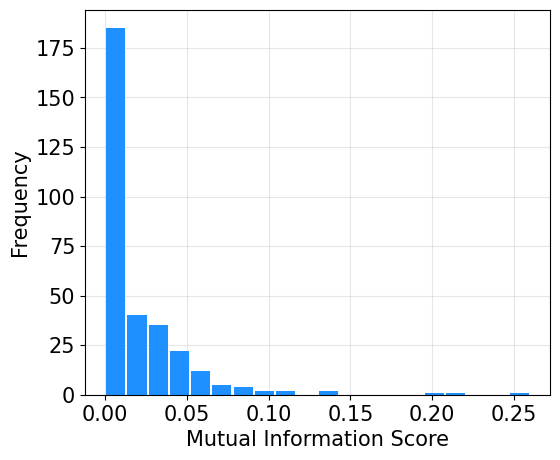

In [325]:
plt.hist(valz, color="dodgerblue", rwidth=0.9, bins=20)
plt.xlabel("Mutual Information Score")
plt.ylabel("Frequency")
plt.show()

In [334]:
k = sorted(mutual_info, key=lambda x: mutual_info[x], reverse=True)
k = [item for item in k if item[0] != "o"]

In [336]:
pairs = []
for item in k:
    pairs.append((item, mutual_info[item]))

In [339]:
pairs

[('j03_2_miscellaneous_expenses', 0.2597123121116931),
 ('j02_1_vehicle_expenses', 0.21901586068252743),
 ('r6_04_2_2', 0.19628192869446437),
 ('r6_03_1_3', 0.13390886679131508),
 ('j03_2_family_events_expenses', 0.13055555555555576),
 ('j02_2_wedding_costs_bride', 0.11665783889189374),
 ('weight_food_drinks', 0.11110561924232742),
 ('weight_food_other', 0.10019117092711838),
 ('m06_3', 0.099288077428211),
 ('r7_06_2_3', 0.08388812239973564),
 ('r7_07_2_3', 0.08143265297630231),
 ('m05', 0.07916090616363292),
 ('r6_04_1_1', 0.0785615974453382),
 ('r3_07_1', 0.0733317829695821),
 ('r7_11_1_3', 0.07300854443129268),
 ('value_food_fish_small', 0.07081409089438662),
 ('k07', 0.0699947705175692),
 ('value_food_other', 0.0678787866886501),
 ('r7_11_1_2', 0.06345548425756231),
 ('m01', 0.06337525755927231),
 ('r3_06_1', 0.0598423079562842),
 ('j02_1_utilities_taxes_fees', 0.05825310685001739),
 ('j03_1_fuel_expenses', 0.0581629843930096),
 ('r7_03_1', 0.0578188555972563),
 ('r7_08_1', 0.05775